In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df_sky = pd.read_csv("Skyserver_12_30_2019 4_49_58 PM.csv")

                 objid          ra        dec         u         g         r  \
0  1237666301628060000   47.372545   0.820621  18.69254  17.13867  16.55555   
1  1237673706652430000  116.303083  42.455980  18.47633  17.30546  17.24116   
2  1237671126974140000  172.756623  -8.785698  16.47714  15.31072  15.55971   
3  1237665441518260000  201.224207  28.771290  18.63561  16.88346  16.09825   
4  1237665441522840000  212.817222  26.625225  18.88325  17.87948  17.47037   

          i         z   run  rerun  camcol  field            specobjid  \
0  16.34662  16.17639  4849    301       5    771  8168632633242440000   
1  17.32780  17.37114  6573    301       6    220  9333948945297330000   
2  15.72207  15.82471  5973    301       1     13  3221211255238850000   
3  15.70987  15.43491  4649    301       3    121  2254061292459420000   
4  17.17441  17.05235  4649    301       3    191  2390305906828010000   

    class  redshift  plate    mjd  fiberid  
0    STAR  0.000115   7255  56597  

<AxesSubplot:>

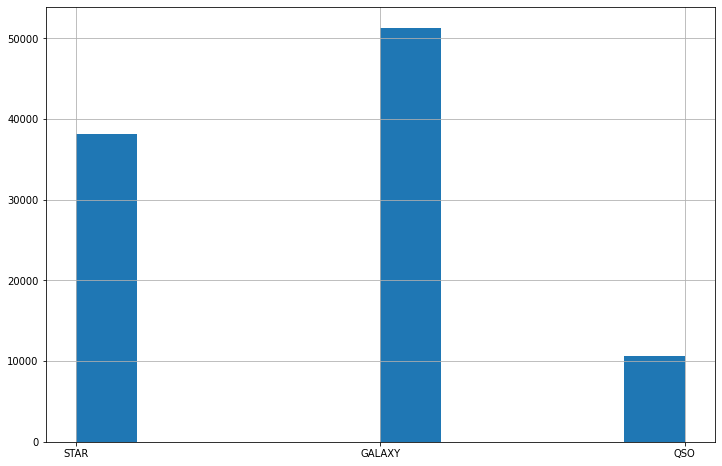

In [3]:
#Basic information about the data set
print(df_sky.head())
print(df_sky.describe())
print(df_sky.info())
df_sky['class'].hist(figsize = (12, 8))

In [4]:
df_dim_sky = df_sky.shape

df_sky.loc[df_sky['class'] == 'STAR', ['u', 'g', 'r', 'i', 'z']]

df_cnames = list(df_sky)

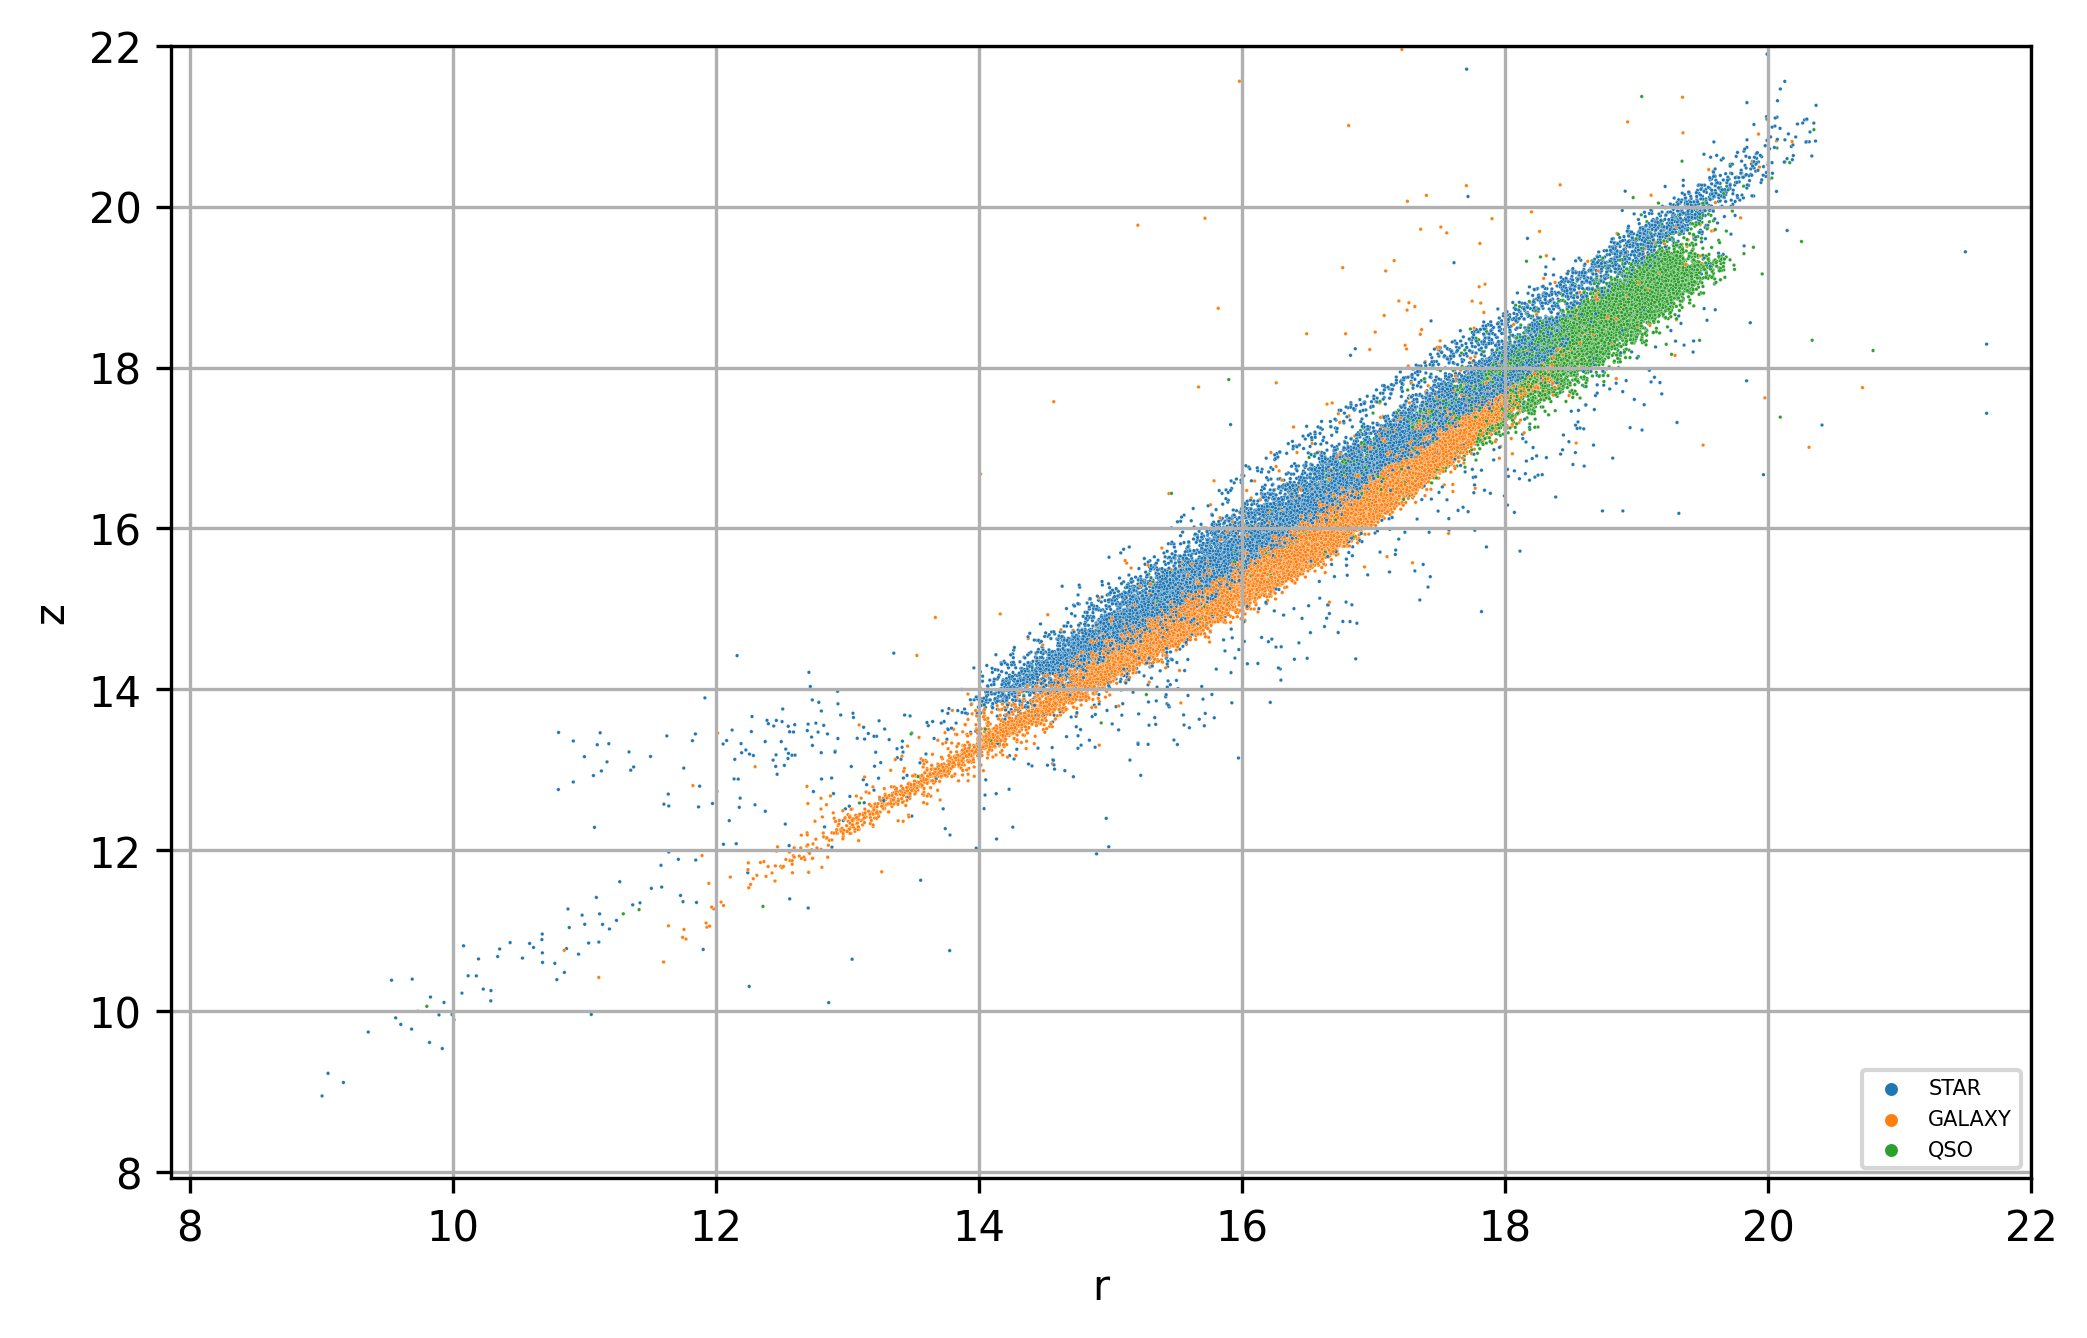

In [5]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 300)

sky_plot = sns.scatterplot(x = 'r', y = 'z', data = df_sky, hue = 'class', s = 0.75)
plt.grid()
plt.xlim(right = 22)
plt.ylim(top = 22) 
plt.legend(fontsize = 5, loc = 4, markerscale = 0.35)

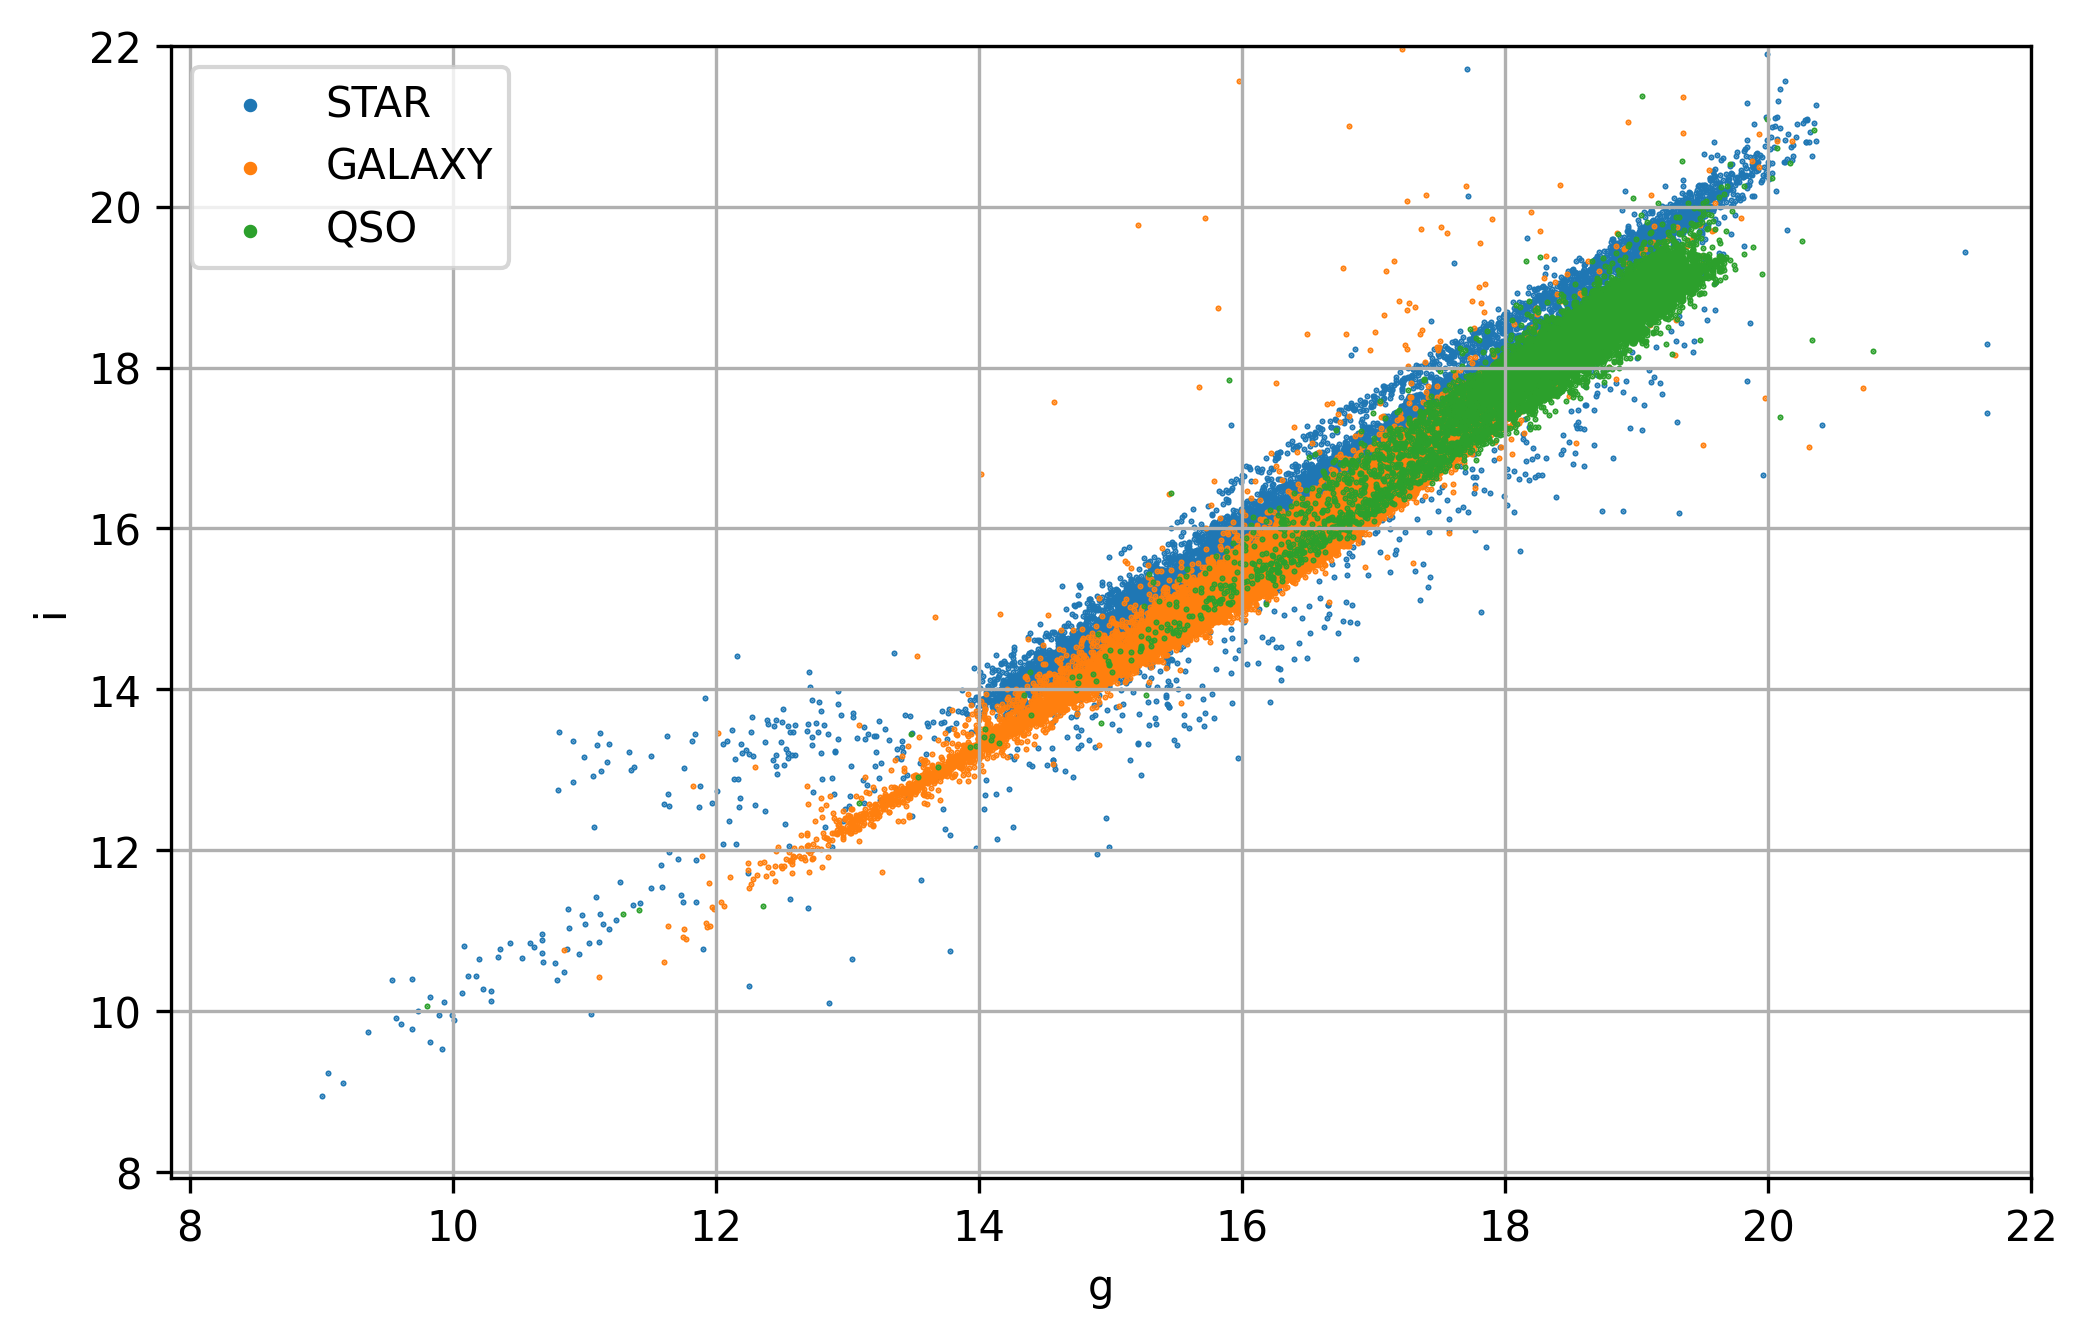

In [6]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 300)

ax.scatter(df_sky.loc[df_sky['class'] == 'STAR', ['r']], 
           df_sky.loc[df_sky['class'] == 'STAR', ['z']], s = 0.2, label = 'STAR')
ax.scatter(df_sky.loc[df_sky['class'] == 'GALAXY', ['r']], 
           df_sky.loc[df_sky['class'] == 'GALAXY', ['z']], s = 0.2, label = 'GALAXY')
ax.scatter(df_sky.loc[df_sky['class'] == 'QSO', ['r']], 
           df_sky.loc[df_sky['class'] == 'QSO', ['z']], s = 0.2, label = 'QSO')
ax.set_xlabel("g")
ax.set_ylabel("i")
ax.grid(True)
plt.xlim(right = 22)
plt.ylim(top = 22) 
plt.legend(markerscale = 5)

In [7]:
# KNN classification

np.random.seed(10)
train_values = np.random.choice(range(df_dim_sky[0]), size = int(df_dim_sky[0]*0.5), replace = False)
mask_values = np.isin(np.array(range(df_dim_sky[0])), train_values, invert = True)
test_values = np.array(range(df_dim_sky[0]))[mask_values]


Y_train = df_sky.loc[train_values,'class']
X_train = df_sky.loc[train_values,['u', 'g', 'r', 'i', 'z', 'redshift']]

Y_test = df_sky.loc[test_values,'class']
X_test = df_sky.loc[test_values,['u', 'g', 'r', 'i', 'z', 'redshift']]

k_values = list(range(1, 10))
misclass = []

knn_classifier2 = KNeighborsClassifier()
knn_grid = {'n_neighbors': np.arange(1, 6)}

knn_clssr_grid = GridSearchCV(knn_classifier2, knn_grid, cv = 5)

knn_clssr_grid.fit(X_train, Y_train)

print(knn_clssr_grid.best_params_)

knn_clssr_grid.predict(X_test)
misclass2 = 1 - knn_clssr_grid.score(X_test, Y_test)

print(f'The test MSE is {misclass2}')

{'n_neighbors': 3}
The test MSE is 0.037719999999999976


In [8]:
df_compare = pd.DataFrame({"Actual" : Y_test, "Predicted": knn_clssr_grid.predict(X_test)})

In [9]:
df_compare['Misclass'] = df_compare['Actual'] != df_compare['Predicted']

In [10]:
len(df_compare.loc[df_compare['Misclass'] == True])/len(df_compare)

0.03772

In [11]:
df_compare['r'] = df_sky.loc[test_values,['r']]
df_compare['z'] = df_sky.loc[test_values,['z']]

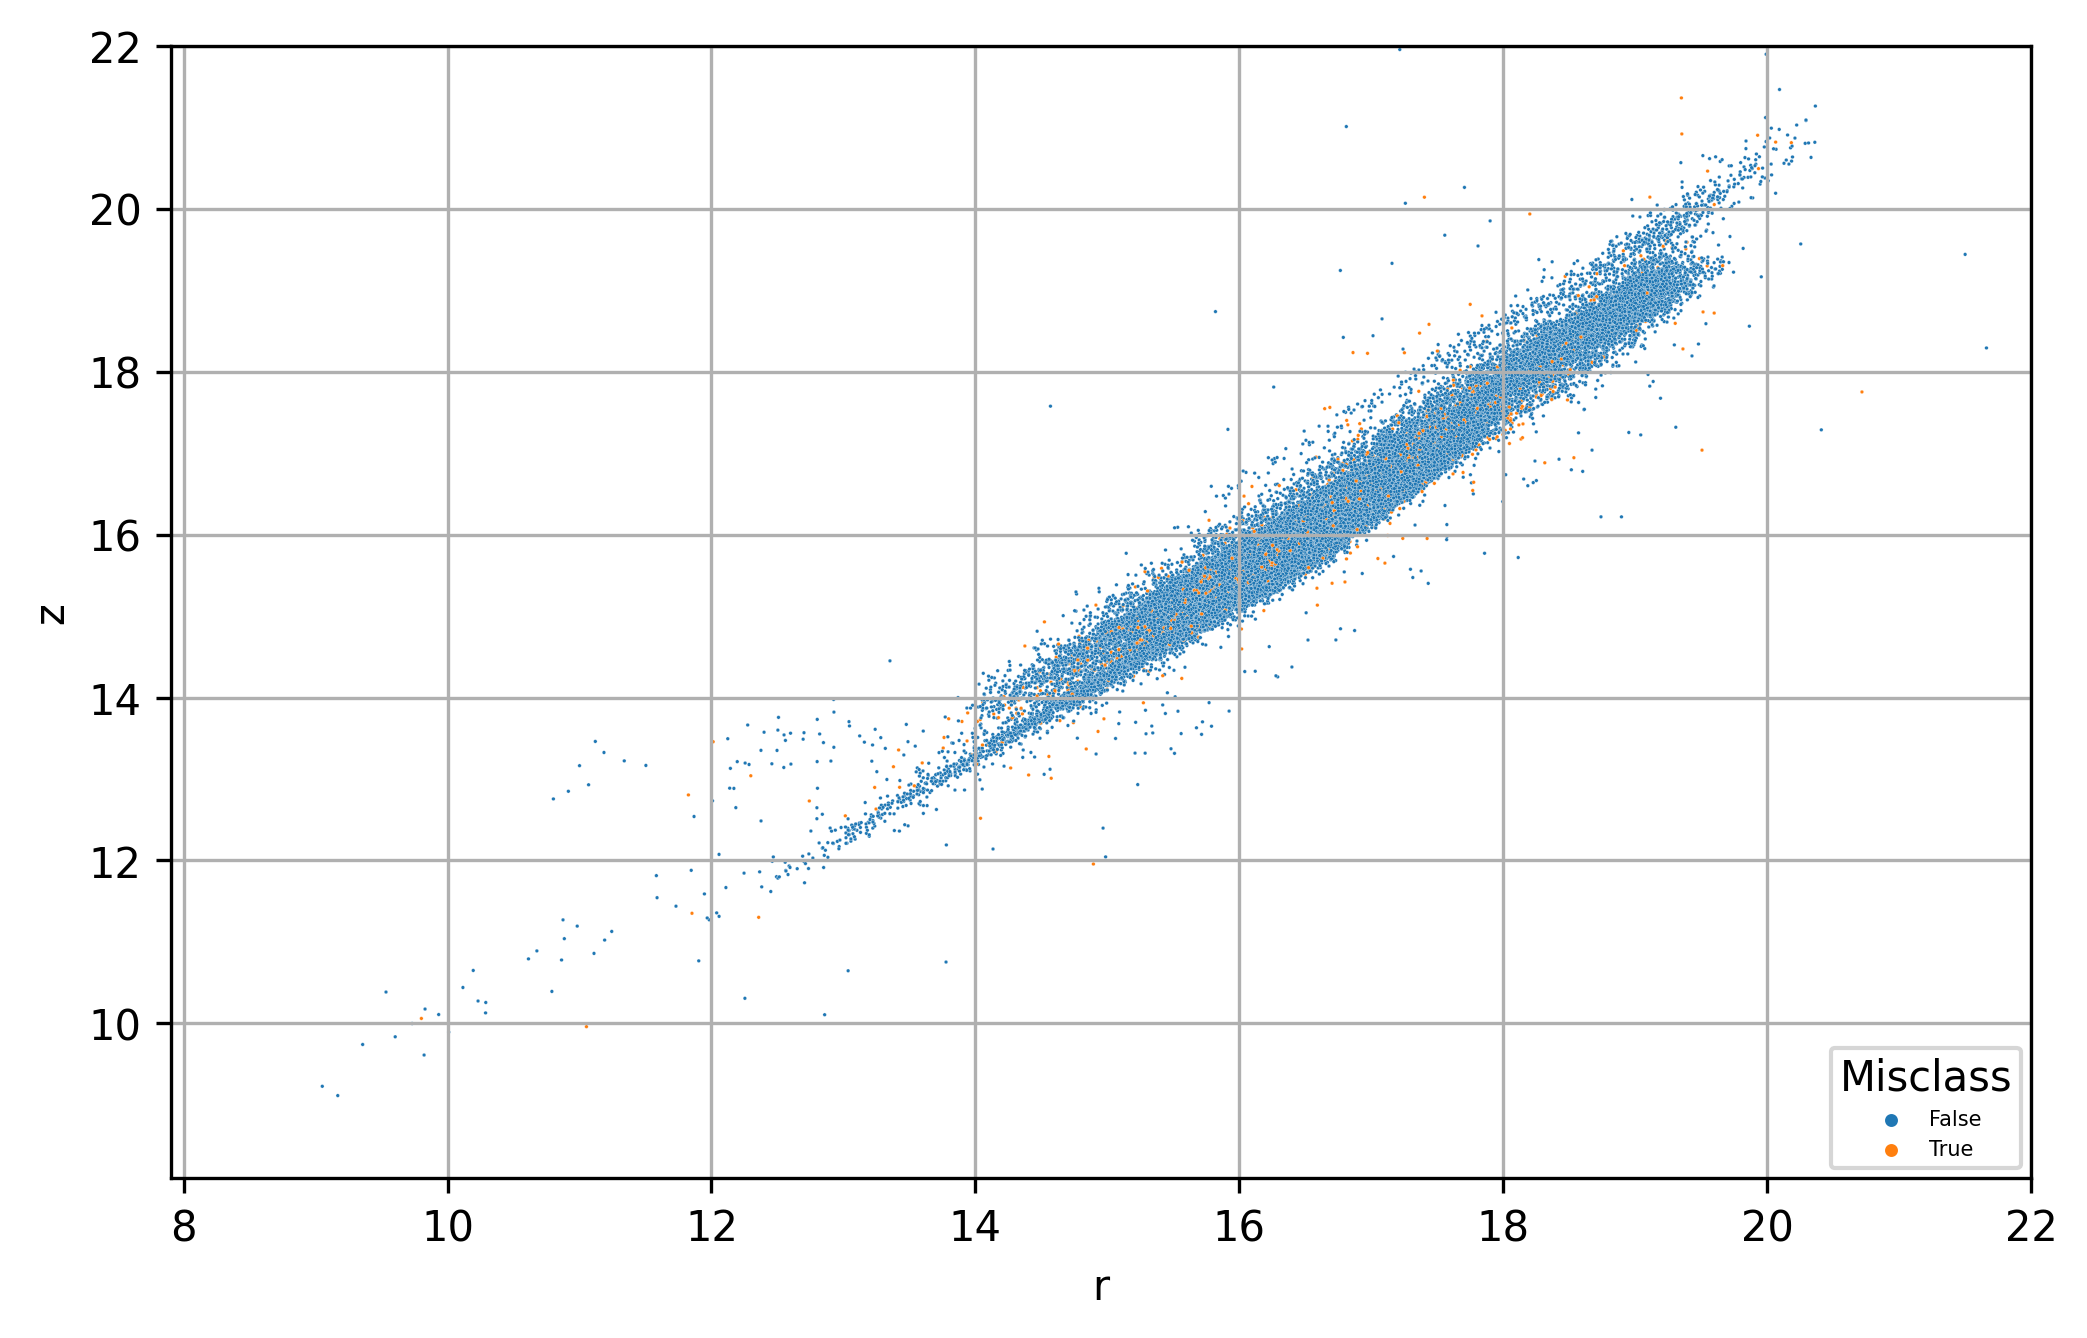

In [12]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 300)

sky_plot = sns.scatterplot(x = 'r', y = 'z', data = df_compare, hue = 'Misclass', s = 0.75)
plt.grid()
plt.xlim(right = 22)
plt.ylim(top = 22) 
plt.legend(fontsize = 5, loc = 4, markerscale = 0.35, title = "Misclass")

In [13]:
# Random Forest
np.random.seed(10)
rf_sky = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 500, n_jobs = -1)
rf_sky.fit(X_train, Y_train)
rf_sky_pred = rf_sky.predict(X_test)

In [14]:
rf_sky_pred

array(['STAR', 'STAR', 'GALAXY', ..., 'QSO', 'STAR', 'GALAXY'],
      dtype=object)

In [15]:
df_compare2 = pd.DataFrame({"Actual" : Y_test, "Predicted": rf_sky_pred})
df_compare2['Misclass'] = df_compare2['Actual'] != df_compare2['Predicted']
df_compare2['r'] = df_sky.loc[test_values,['r']]
df_compare2['z'] = df_sky.loc[test_values,['z']]

len(df_compare2.loc[df_compare2['Misclass'] == True])/len(df_compare2)

0.00814

Predicted  GALAXY   QSO   STAR
Actual                        
GALAXY      25502    73     38
QSO           273  4942      6
STAR           17     0  19149
The importance of each feature is [0.03497606 0.03842712 0.04764446 0.07382269 0.0750828  0.73004687]


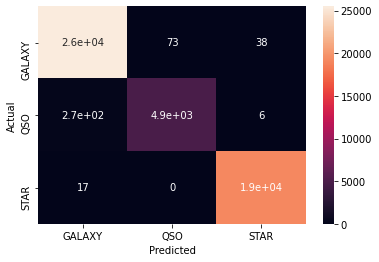

In [16]:
confusion_matrix = pd.crosstab(Y_test, rf_sky_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print("="*100)
print(confusion_matrix)
print("="*100)
print(f"The importance of each feature is {rf_sky.feature_importances_}")
print("="*100)

In [17]:
df_compare2

,Actual,Predicted,Misclass,r,z
1,STAR,STAR,False,17.24116,17.37114
2,STAR,STAR,False,15.55971,15.82471
3,GALAXY,GALAXY,False,16.09825,15.43491
4,GALAXY,GALAXY,False,17.47037,17.05235
10,GALAXY,GALAXY,False,17.41365,16.73926
...,...,...,...,...,...
99991,GALAXY,GALAXY,False,16.92447,16.38078
99993,STAR,STAR,False,18.09178,18.02603
99995,QSO,QSO,False,18.65659,18.60917
99996,STAR,STAR,False,17.16037,17.14419


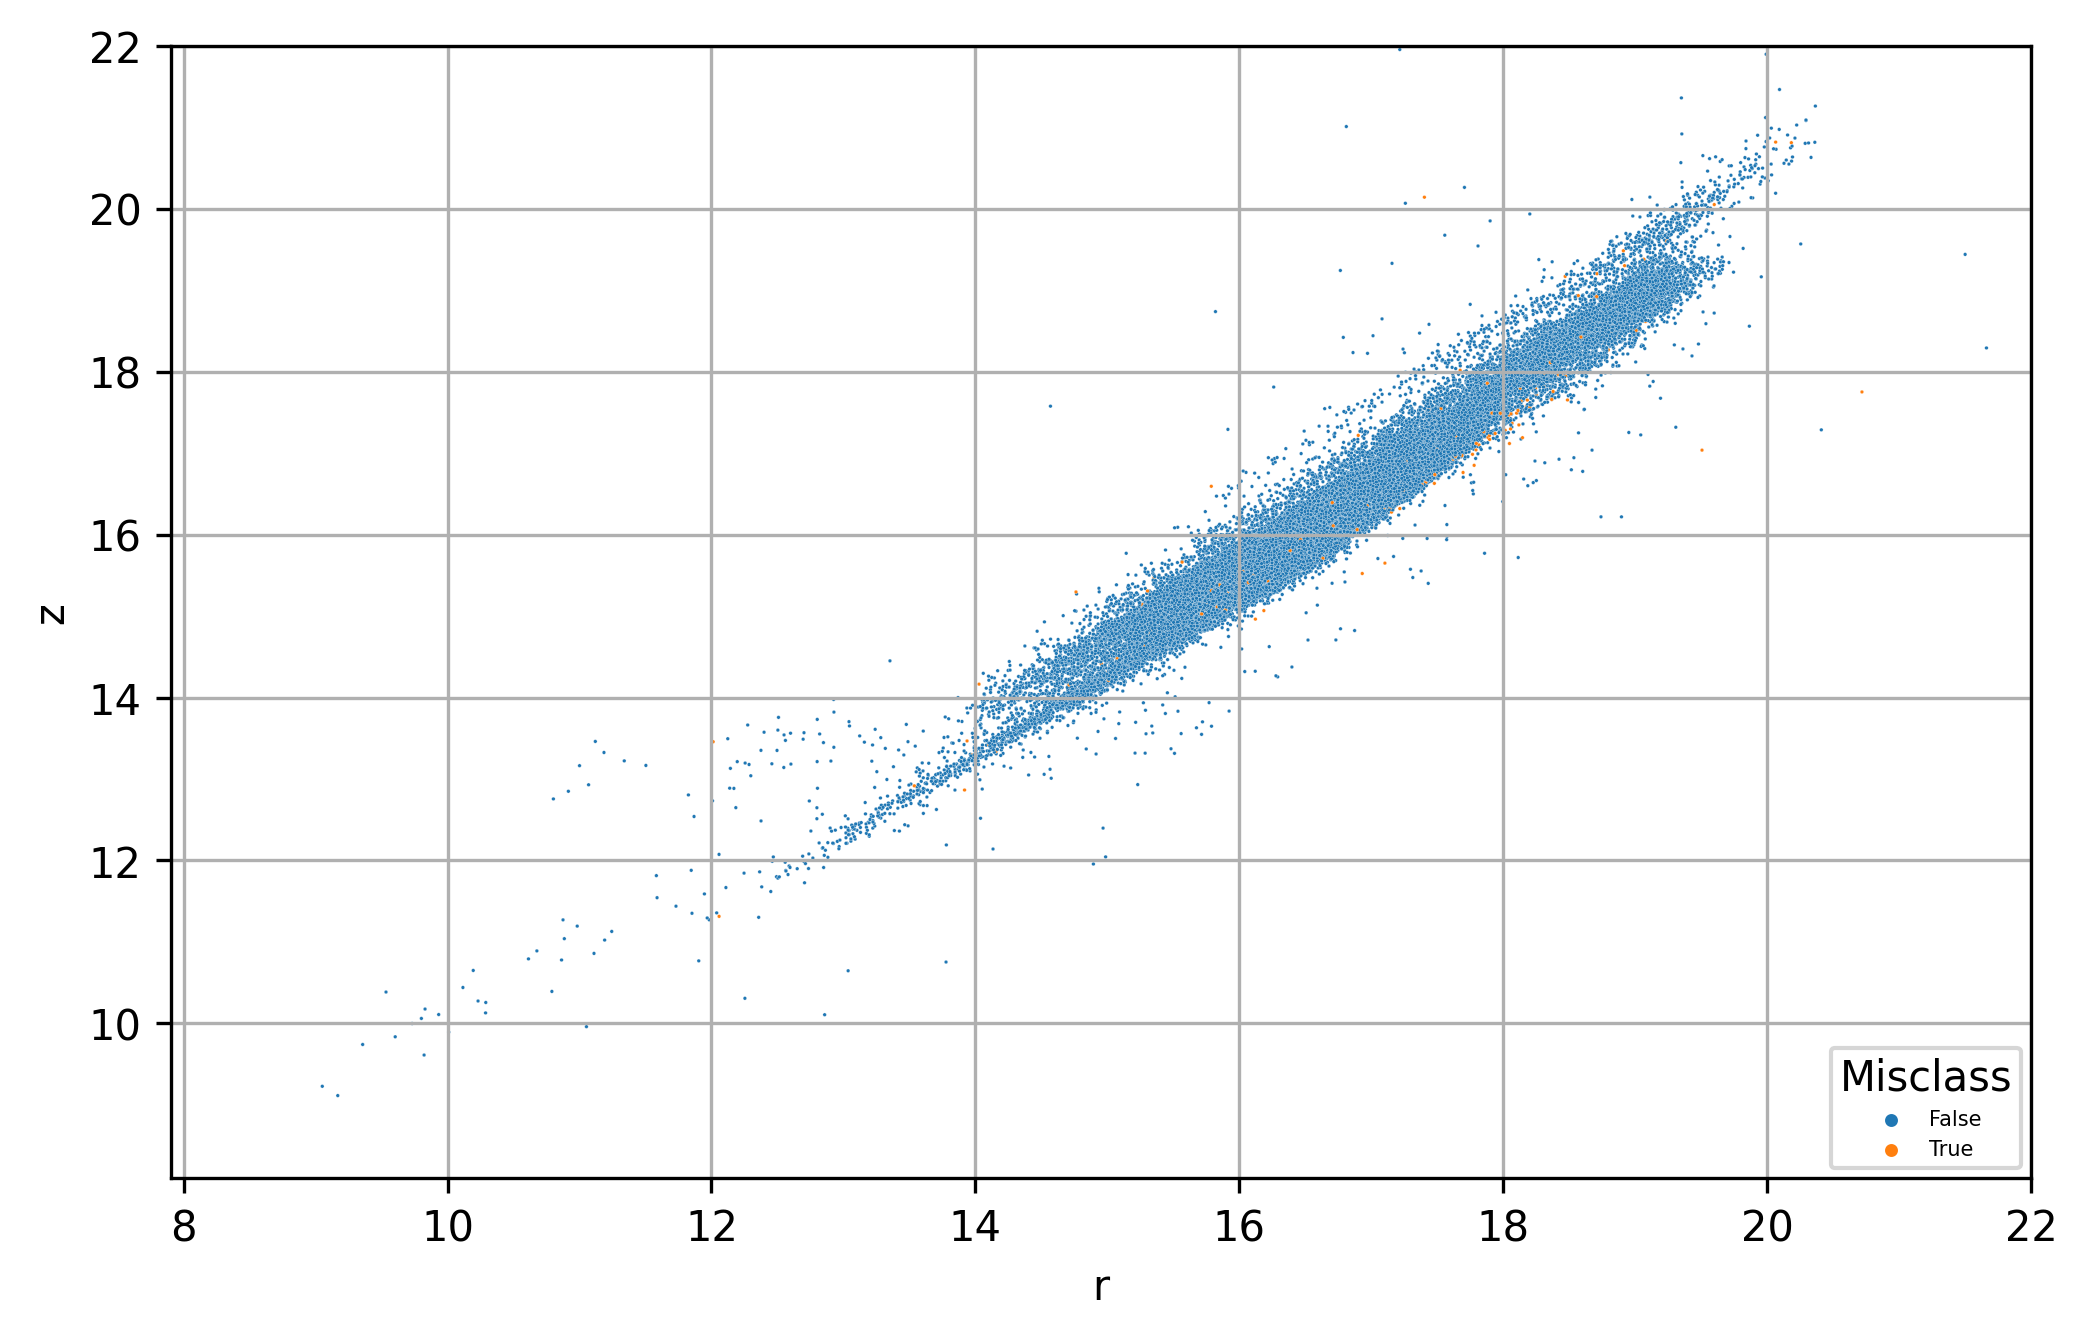

In [18]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 300)

sky_plot = sns.scatterplot(x = 'r', y = 'z', data = df_compare2, hue = 'Misclass', s = 0.75)
plt.grid()
plt.xlim(right = 22)
plt.ylim(top = 22) 
plt.legend(fontsize = 5, loc = 4, markerscale = 0.35, title = "Misclass")

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'redshift'),
  Text(0, 1, 'z'),
  Text(0, 2, 'i'),
  Text(0, 3, 'r'),
  Text(0, 4, 'g'),
  Text(0, 5, 'u')])

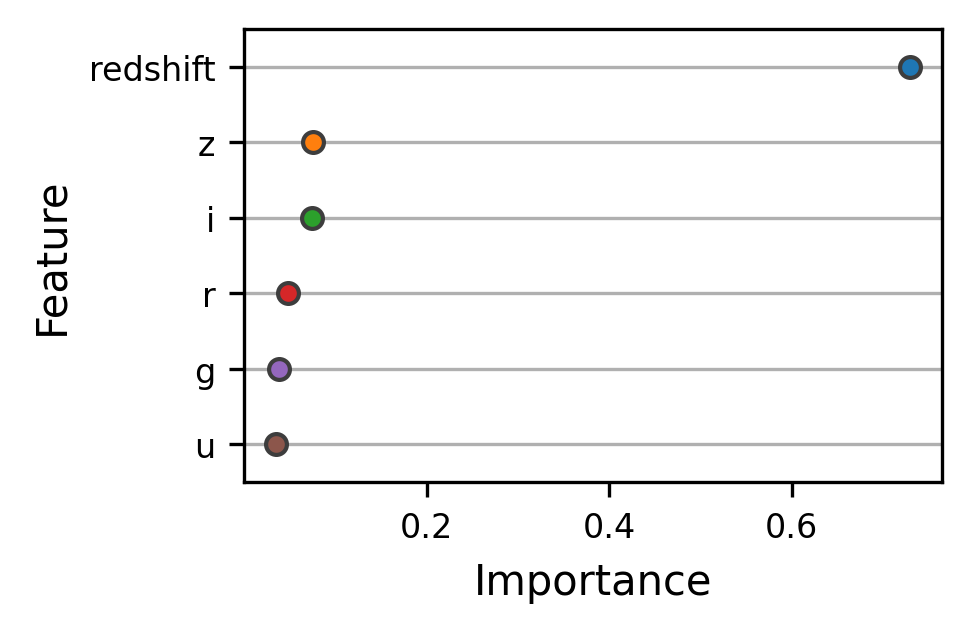

In [20]:
features_ = ['u', 'g', 'r', 'i', 'z', 'redshift']
feature_imp = rf_sky.feature_importances_

fig, ax = plt.subplots(figsize = (3,2), dpi = 300)

fea_imp_tab = pd.DataFrame([features_, feature_imp])

fea_imp_tab = fea_imp_tab.T
fea_imp_tab = fea_imp_tab.rename(columns = {0: "Feature", 1:"Importance"} )

fea_imp_tab = fea_imp_tab.sort_values(by = "Importance", ascending = False)

#print(fea_imp_tab)

sns.stripplot(x = "Importance", y = "Feature", data = fea_imp_tab, linewidth = 1, jitter = False)
ax.yaxis.grid(True)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)